This notebook includes all of the code for the experients and analyses.  It uses a python v3 and tensorflow v1.14 port of the SEM model, and should run as is in Colab.  

I've hidden most of the code except for the relevant parameters to switch between Blocked > Interleaved and Interleaved > Blocked.  Hopefully the plots are clear, but let me know if they are not.



## Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

from glob import glob
import json

import re
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os

sns.set_context('talk')

# Load Data

## Human Behavioral Data

In [2]:
trial_by_trial = pd.read_csv('./data/BehDataTrialXTrial.csv', index_col=1)
beh_data = pd.read_csv('./data/BehData_Test.csv', index_col=1)

## Load Simulation Data
We have two files for each model: the file containing Blocked, Interleaved and Instructed (which are the data that was fit) and another file containing Blocked, Interelaved, and the Inserted conditions.  We take blocked and interleaved from the first, as this was the fit data.

### Load MLP Data

In [3]:
## MLP Data
file = './data/trial_X_trial_MLP_nhiddenNone_e1e-05_' 
file += 'lr0.005_n8_d0.0_logalfa_-208.0_loglmda_208.0__nosplit_online.csv'
mlp_trial_data = pd.read_csv(file)

file = './data/results_MLP_nhiddenNone_e1e-05_' 
file += 'lr0.005_n8_d0.0_logalfa_-208.0_loglmda_208.0__nosplit_online.csv'
mlp_results = pd.read_csv(file)

## LSTM Data
file = './data/trial_X_trial_VanillaLSTM_nhiddenNone' 
file += '_e1e-05_lr0.005_n2_d0.0_logalfa_-208.0_loglmda_208.0__nosplit_online.csv'
lstm_trial_data = pd.read_csv(file)

file = './data/results_VanillaLSTM_nhiddenNone' 
file += '_e1e-05_lr0.005_n2_d0.0_logalfa_-208.0_loglmda_208.0__nosplit_online.csv'
lstm_results = pd.read_csv(file)


## SEM Data
file = './data/trial_X_trial_VanillaLSTM_nhiddenNone' 
file += '_e1e-05_lr0.05_n2_d0.0_logalfa_16.0_loglmda_8.0__online.csv'
sem_lstm_trial_data = pd.read_csv(file)

file = './data/results_VanillaLSTM_nhiddenNone' 
file += '_e1e-05_lr0.05_n2_d0.0_logalfa_16.0_loglmda_8.0__online.csv'
sem_lstm_results = pd.read_csv(file)

# Model Fit statistics

In [4]:
def kl_pq(mu_1, mu_2, sd_1, sd_2):
    # p(x) = N(x; mu_1, sd_1)
    # q(x) = N(x; mu_2, sd_2)
    
    return np.log(sd_2) - np.log(sd_1) + \
        (sd_1 ** 2 + (mu_1 - mu_2)**2) / (2 * (sd_2**2) ) - 0.5

def get_error(model_data):

#     model_data = pd.read_csv(file)
    relevant_conds = model_data.Condition.apply(
        lambda x: (x != 'Late') | (x != 'Early') | (x != 'Middle')
    )
    
    model_grouped = model_data[relevant_conds].groupby(['Condition', 't'])

    
    MSE = 0
    KL = 0

    for cond in set(model_data.Condition):
        mu_model = model_grouped.mean().loc[cond]['Accuracy'].values
        sd_model = model_grouped.std().loc[cond]['Accuracy'].values

        mu_beh = trial_by_trial.loc[:, '{} Mean'.format(cond)].values
        sd_beh = trial_by_trial.loc[:, '{} StdDev'.format(cond)].values

        MSE += np.mean((mu_beh - mu_model) ** 2)
        KL  += np.sum(kl_pq(mu_beh, mu_model, sd_beh, sd_model))

    return {
            'KL': MSE,
            'MSE': KL,
        }

In [5]:
model_fit_stats = []


stats_dict = get_error(mlp_trial_data)
stats_dict['Model'] = 'MLP'
model_fit_stats.append(stats_dict)

stats_dict = get_error(lstm_trial_data)
stats_dict['Model'] = 'LSTM'
model_fit_stats.append(stats_dict)

stats_dict = get_error(sem_lstm_trial_data)
stats_dict['Model'] = 'SEM'
model_fit_stats.append(stats_dict)


model_fit_stats = pd.DataFrame(model_fit_stats)
model_fit_stats

,KL,MSE,Model
0,0.261070,4879.145088,MLP
1,0.107943,2922.245089,LSTM
2,0.064415,703.773369,SEM


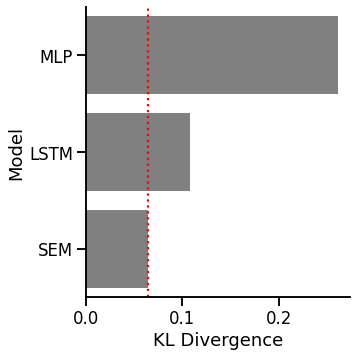

In [6]:
sns.catplot(data=model_fit_stats.loc[:, :], x='KL', y='Model', kind='bar', color='gray')
plt.gca().axvline(x=np.min(model_fit_stats.loc[:, 'KL']), ls=':', c='r')
plt.xlabel('KL Divergence')
plt.savefig('ModelComparisons_KL.png', dpi=300)

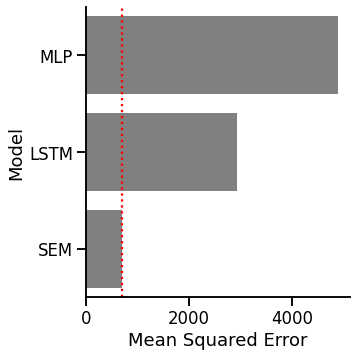

In [7]:
sns.catplot(data=model_fit_stats, x='MSE', y='Model', kind='bar', color='gray')
plt.gca().axvline(x=np.min(model_fit_stats.loc[:, 'MSE']), ls=':', c='r')

plt.xlabel('Mean Squared Error')
plt.savefig('ModelComparisons_MSE.png', dpi=300)

# Error Analysis

In [8]:
def plot_acc_by_time(df, condition):
    sns.relplot(data=df[df.Condition==condition],
            x='t', y='Accuracy', kind='line', aspect=2, height=3)
    plt.title(condition)
    plt.xlabel('Story')
    plt.ylim(0, 1.0)
    plt.xlim(0, 200)
    return plt.gcf()

def plot_pe_by_time(df, condition):
    sns.relplot(data=df[df.Condition==condition],
            x='t', y='pe', kind='line', aspect=2, height=3)
    plt.title(condition)
    plt.xlabel('Story')
    plt.ylabel('Prediction Error')
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    return plt.gcf()

def plot_intXinst_by_time(df, measure='Accuracy'):
#     df
    sns.relplot(data=df[(df.Condition=='Interleaved') | 
                       (df.Condition=='Instructed')],
            x='t', y=measure, kind='line', hue='Condition',
                aspect=2, height=3)
    plt.xlabel('Story')
    plt.ylabel('Accuracy')
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    return plt.gcf()

In [9]:
cond_order='Blocked Early Middle Late Interleaved Instructed'.split()

model = 'SEM'
df = sem_lstm_trial_data


for cond in cond_order + ["Instructed"]:
    plot_acc_by_time(df, cond)
    plt.tight_layout()
    plt.savefig('AccXTime_{}_{}.png'.format(model, cond), dpi=300)
    plt.close()
    
    plot_pe_by_time(df, cond)
    plt.tight_layout()
    plt.savefig('PeXTime_{}_{}.png'.format(model, cond), dpi=300)
    plt.close()
    
plot_intXinst_by_time(df)
plt.xlabel('Story')
plt.title('SEM')
plt.ylabel('Accuracy')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Instructed_vs_Interleaved_Acc_{}.png'.format(model), dpi=300)
plt.close()

plot_intXinst_by_time(df, measure='pe')
plt.xlabel('Story')
plt.title('SEM')
plt.ylabel('PE')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Instructed_vs_Interleaved_pe_{}.png'.format(model), dpi=300)
plt.close()

In [10]:
model = 'LSTM'
df = lstm_trial_data


for cond in cond_order:
    plot_acc_by_time(df, cond)
    plt.tight_layout()
    plt.savefig('AccXTime_{}_{}.png'.format(model, cond), dpi=300)
    plt.close()
    
    plot_pe_by_time(df, cond)
    plt.tight_layout()
    plt.savefig('PeXTime_{}_{}.png'.format(model, cond), dpi=300)
    plt.close()
    
plot_intXinst_by_time(df)
plt.xlabel('Story')
plt.title('LSTM')
plt.ylabel('Accuracy')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Instructed_vs_Interleaved_Acc_{}.png'.format(model), dpi=300)
plt.close()

plot_intXinst_by_time(df, measure='pe')
plt.xlabel('Story')
plt.title('LSTM')
plt.ylabel('PE')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Instructed_vs_Interleaved_pe_{}.png'.format(model), dpi=300)
plt.close()

In [11]:
model = 'MLP'
df = mlp_trial_data

for cond in cond_order:
    plot_acc_by_time(df, cond)
    plt.tight_layout()
    plt.savefig('AccXTime_{}_{}.png'.format(model, cond), dpi=300)
    plt.close()
    
    plot_pe_by_time(df, cond)
    plt.tight_layout()
    plt.savefig('PeXTime_{}_{}.png'.format(model, cond), dpi=300)
    plt.close()
    
plot_intXinst_by_time(df)
plt.xlabel('Story')
plt.title('MLP')
plt.ylabel('Accuracy')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Instructed_vs_Interleaved_Acc_{}.png'.format(model), dpi=300)
plt.close()

plot_intXinst_by_time(df, measure='pe')
plt.xlabel('Story')
plt.ylabel('PE')
plt.title('MLP')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('Instructed_vs_Interleaved_pe_{}.png'.format(model), dpi=300)
plt.close()

In [12]:
# sem_lstm_trial_data

def get_total_n_events(e_hat):
    return np.array([np.max(e_hat[:ii]) for ii in range(1, len(e_hat) + 1)])

# trial_data = pd.read_csv(load_file)
sem_lstm_trial_data['N Total Events'] = 0.0

for b in set(sem_lstm_trial_data.batch):
    batch_data = sem_lstm_trial_data[sem_lstm_trial_data.batch == b]
    for cond in set(sem_lstm_trial_data.Condition):
        idx = sem_lstm_trial_data.loc[sem_lstm_trial_data.Condition == cond, :].index
        sem_lstm_trial_data.loc[idx, 'N Total Events'] = sem_lstm_trial_data.loc[idx, 'e_hat']
        
sem_lstm_trial_data['N Total Events'] += 1

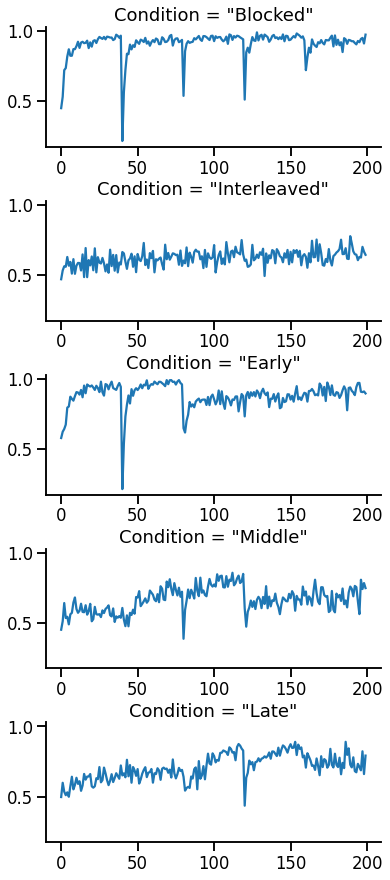

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(6, 15), sharey=True)

axes[0].plot(trial_by_trial['Blocked Mean'])
axes[1].plot(trial_by_trial['Interleaved Mean'])
axes[2].plot(trial_by_trial['Early Mean'])
axes[3].plot(trial_by_trial['Middle Mean'])
axes[4].plot(trial_by_trial['Late Mean'])

axes[0].set_title('Condition = "Blocked"')
axes[1].set_title('Condition = "Interleaved"')
axes[2].set_title('Condition = "Early"')
axes[3].set_title('Condition = "Middle"')
axes[4].set_title('Condition = "Late"')

# help(sns.relplot)
plt.subplots_adjust(hspace=0.45)
sns.despine()
# fig.get_size

### trial by trial error

In [14]:
trial_by_trial

,Unnamed: 0,Blocked Mean,Interleaved Mean,Early Mean,Middle Mean,Late Mean,Instructed Mean,Blocked StdDev,Interleaved StdDev,Early StdDev,Middle StdDev,Late StdDev,Instructed StdDev
t,,,,,,,,,,,,,
0,0,0.450360,0.470288,0.577810,0.450856,0.497531,0.437500,0.501249,0.487302,0.497887,0.502753,0.503535,0.500000
1,1,0.531633,0.532713,0.622421,0.511164,0.598901,0.579710,0.496320,0.494410,0.488719,0.505432,0.495362,0.497222
2,2,0.720819,0.562386,0.641971,0.640693,0.535714,0.555556,0.448816,0.492848,0.480277,0.484374,0.504077,0.500391
3,3,0.735830,0.558931,0.673140,0.534179,0.510692,0.430769,0.440724,0.500549,0.459289,0.503967,0.499688,0.499038
4,4,0.818325,0.628748,0.794226,0.542948,0.530864,0.671053,0.388218,0.473767,0.408293,0.501980,0.504043,0.472953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.920087,0.629630,0.970402,0.561983,0.712500,0.688889,0.274456,0.473969,0.169234,0.503595,0.461168,0.468179
196,196,0.943584,0.624803,0.907396,0.806818,0.687831,0.729167,0.231785,0.487467,0.294442,0.392854,0.468723,0.449093
197,197,0.950606,0.701003,0.904768,0.740498,0.823214,0.750000,0.219428,0.456047,0.294962,0.445260,0.389212,0.436931


In [15]:



### Sem error

model_grouped = sem_lstm_trial_data.groupby(['Condition', 't'])

sem_error = {}
sem_KL = {}

for cond in set(sem_lstm_trial_data.Condition):
    mu_model = model_grouped.mean().loc[cond]['Accuracy'].values
    sd_model = model_grouped.std().loc[cond]['Accuracy'].values
    
    mu_beh = trial_by_trial.loc[:, '{} Mean'.format(cond)].values
    sd_beh = trial_by_trial.loc[:, '{} StdDev'.format(cond)].values
    
    sem_error[cond] = (mu_model - mu_beh)
    sem_KL[cond] = kl_pq(mu_beh, mu_model, sd_beh, sd_model)
    
    
### LSTM Error

model_grouped = lstm_trial_data.groupby(['Condition', 't'])

lstm_error = {}
lstm_KL = {}

for cond in set(lstm_trial_data.Condition):
    mu_model = model_grouped.mean().loc[cond]['Accuracy'].values
    sd_model = model_grouped.std().loc[cond]['Accuracy'].values
    
    mu_beh = trial_by_trial.loc[:, '{} Mean'.format(cond)].values
    sd_beh = trial_by_trial.loc[:, '{} StdDev'.format(cond)].values
    
    lstm_error[cond] = (mu_model - mu_beh)
    lstm_KL[cond] = kl_pq(mu_beh, mu_model, sd_beh, sd_model)
    
# fig, axes = plt.subplots(6, 1, figsize=(5, 18), sharex=True, sharey=True)

for cond in set(lstm_trial_data.Condition):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(sem_error[cond], label='SEM')
    ax.plot(lstm_error[cond], label='LSTM')
    ax.axhline(y=0, ls=':', c='r')
    ax.set_ylim([-.4, .4])
    ax.set_yticks(np.arange(-.4, .41, .2))
    ax.set_ylabel('Model Error')
    ax.set_xlabel('Time')
    ax.set_title(cond)
    ax.legend(loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.savefig('ErrorComparison_{}.png'.format(cond), dpi=300)
    plt.close()

In [16]:
help(plt.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    Adjust the subplot layout parameters.
    
    Unset parameters are left unmodified; initial values are given by
    :rc:`figure.subplot.[name]`.
    
    Parameters
    ----------
    left : float, optional
        The position of the left edge of the subplots,
        as a fraction of the figure width.
    right : float, optional
        The position of the right edge of the subplots,
        as a fraction of the figure width.
    bottom : float, optional
        The position of the bottom edge of the subplots,
        as a fraction of the figure height.
    top : float, optional
        The position of the top edge of the subplots,
        as a fraction of the figure height.
    wspace : float, optional
        The width of the padding between subplots,
        as a fraction of the average axes width.
    hspace : float, optional


In [17]:
order = 'Blocked Early Middle Late Interleaved Instructed'.split()

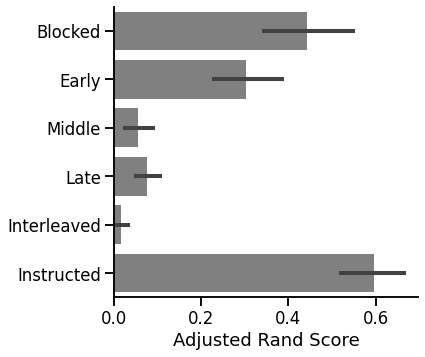

In [18]:
sns.catplot(data=sem_lstm_results[sem_lstm_results.Trials =='All'],
                y='Condition', x='adjRand', kind='bar', 
            order=order, aspect=1.25, color='gray')
plt.xlabel('Adjusted Rand Score')
plt.ylabel('')
plt.savefig('SEM_Adjusted_RandScore.png', dpi=300)


In [19]:
x0 = sem_lstm_results.loc[(sem_lstm_results.Trials =='All') & (sem_lstm_results.Condition == 'Blocked'), 'adjRand'].values
x1 = sem_lstm_results.loc[(sem_lstm_results.Trials =='All') & (sem_lstm_results.Condition == 'Interleaved'), 'adjRand'].values
from scipy.stats import ttest_ind

ttest_ind(x0, x1)


Ttest_indResult(statistic=8.440497510496169, pvalue=2.8873427781733215e-13)

In [20]:
x0 = sem_lstm_results.loc[(sem_lstm_results.Trials =='All') & (sem_lstm_results.Condition == 'Instructed'), 'adjRand'].values
x1 = sem_lstm_results.loc[(sem_lstm_results.Trials =='All') & (sem_lstm_results.Condition == 'Interleaved'), 'adjRand'].values
from scipy.stats import ttest_ind

ttest_ind(x0, x1)



Ttest_indResult(statistic=15.230457199722201, pvalue=1.3962369096764097e-27)

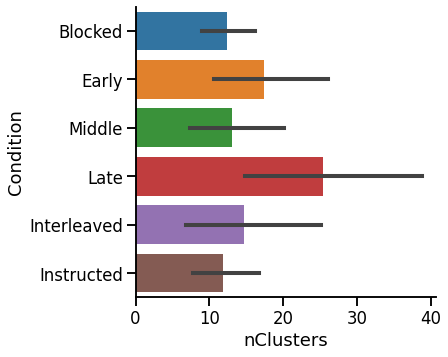

In [21]:
sns.catplot(data=sem_lstm_results[sem_lstm_results.Trials =='All'],
                y='Condition', x='nClusters', kind='bar', 
            order=order, aspect=1.25)




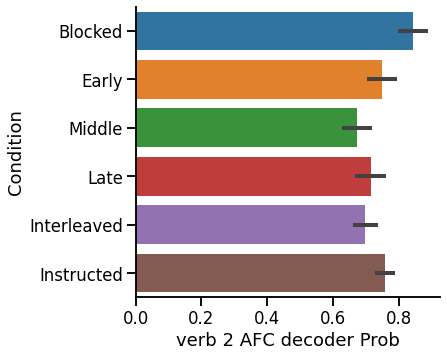

In [22]:
sns.catplot(data=sem_lstm_results[sem_lstm_results.Trials =='Test'],
                y='Condition', x='verb 2 AFC decoder Prob', kind='bar', 
            order=order, aspect=1.25)


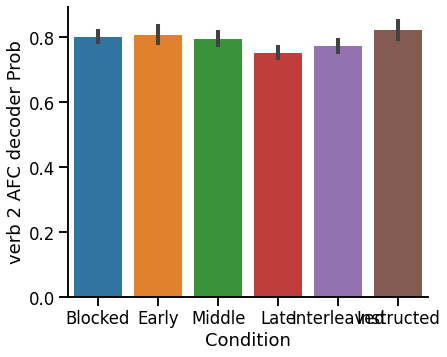

In [23]:
sns.catplot(data=lstm_results[lstm_results.Trials =='Test'],
                x='Condition', y='verb 2 AFC decoder Prob', kind='bar', 
            order=order, aspect=1.25)



In [24]:
beh_data

,Unnamed: 0,Mean,StDev,StErr,n
Condition,,,,,
Blocked,0,0.916167,0.126164,0.016425,59
Interleaved,1,0.647374,0.198328,0.024987,63
Early,2,0.902847,0.137743,0.021006,43
Middle,3,0.691278,0.197567,0.029784,44
Late,4,0.746875,0.205878,0.034313,36
Instructed,5,0.677688,0.205062,0.036830,31


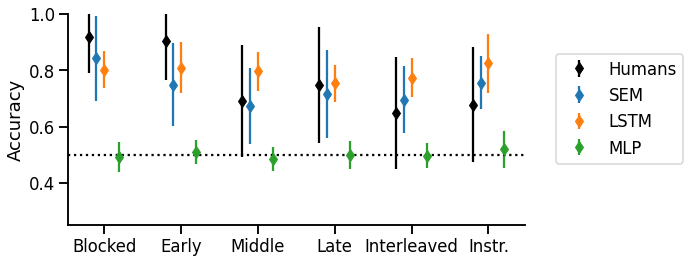

In [25]:
model_label = 'SEM'
rnn_label = 'LSTM'

means_hum = []
sds_hum = []
ses_hum = []

plt.figure(figsize=(10, 4))


order = 'Blocked Early Middle Late Interleaved Instructed'.split()

for cond in order:
    x, sd, se = beh_data.loc[cond, ['Mean', 'StDev', 'StErr']] 
    means_hum.append(x)
    sds_hum.append(sd)
    ses_hum.append(se)

plt.errorbar(x=np.arange(0,6)-0.2, y=means_hum, yerr=sds_hum, color='k',
             ls='None', marker='d', label='Humans')

grouped = sem_lstm_results[(sem_lstm_results.Trials == 'Test')].groupby('Condition')
means = grouped.mean()['verb 2 AFC decoder Prob']
sds =  grouped.std()['verb 2 AFC decoder Prob']

order = 'Blocked Early Middle Late Interleaved Instructed'.split()
means = means[order]
sds = sds[order]
plt.errorbar(x=np.arange(0,6)-0.1, y=means, yerr=sds, ls='None',
             marker='d', label='SEM')


grouped_lstm = lstm_results[(lstm_results.Trials == 'Test')].groupby('Condition')
means_lstm = grouped_lstm.mean()['verb 2 AFC decoder Prob']
sds_lstm =  grouped_lstm.std()['verb 2 AFC decoder Prob']
means_lstm = means_lstm[order]
sds_lstm = sds_lstm[order]
plt.errorbar(x=np.arange(0,6)+0.0, y=means_lstm, yerr=sds_lstm, ls='None',
             marker='d', label='LSTM')


# grouped_semmlp = sem_mlp_results[(sem_mlp_results.Trials == 'Test')].groupby('Condition')
# means_semmlp = grouped_semmlp.mean()['verb 2 AFC decoder Prob']
# sds_semmlp =  grouped_semmlp.std()['verb 2 AFC decoder Prob']
# means_semmlp = means_semmlp[order]
# sds_semmlp = sds_semmlp[order]
# plt.errorbar(x=np.arange(0,5)+0.1, y=means_semmlp, yerr=sds_semmlp, ls='None',
#              marker='d', label='SEM-MLP')

# order = 'Blocked Early Middle Late Interleaved'.split()
grouped_mlp = mlp_results[(mlp_results.Trials == 'Test')].groupby('Condition')
means_mlp = grouped_mlp.mean()['verb 2 AFC decoder Prob']
sds_mlp =  grouped_mlp.std()['verb 2 AFC decoder Prob']
means_mlp = means_mlp[order]
sds_mlp = sds_mlp[order]
plt.errorbar(x=np.arange(0,6)+0.2, y=means_mlp, yerr=sds_mlp, ls='None',
             marker='d', label='MLP')

plt.xticks(np.arange(0, 6), labels=['Blocked', 'Early', 'Middle', 'Late', 'Interleaved', 'Instr.'])
plt.legend(bbox_to_anchor=(1.05, 0.85), loc='upper left')
plt.ylim(0.250, 1.0)
plt.axhline(y=0.5, ls=':', color='k')
plt.ylabel('Accuracy')
plt.tight_layout()
sns.despine()
plt.savefig('AccXConditionXModel.png', dpi=300)

In [26]:
['Blocked', 'Early', 'Middle', 'Late', 'Interleaved', 'Instr.']

['Blocked', 'Early', 'Middle', 'Late', 'Interleaved', 'Instr.']

In [27]:
order

['Blocked', 'Early', 'Middle', 'Late', 'Interleaved', 'Instructed']

In [28]:
sds_hum

[0.12616420593485705,
 0.13774322773959508,
 0.19756739819392535,
 0.2058782376652672,
 0.1983278811838466,
 0.20506180876910013]

In [29]:
sem_lstm_results

,Unnamed: 0,index,Trials,adjRand,nClusters,pe,pe (probes),verb decoder Accuracy,verb decoder Accuracy Prob,verb 2 AFC decoder Prob,batch,Condition,cluster re-use
0,0,6,All,0.222623,3,0.493545,0.338331,0.627500,0.557051,0.814123,0,Early,NaN
1,1,7,Training,0.193395,3,0.511627,0.366494,0.571875,0.498473,0.781680,0,Early,NaN
2,2,8,Test,0.344262,2,0.421218,0.225680,0.850000,0.791365,0.943899,0,Early,1.0
3,3,9,All,0.026633,83,0.718973,0.713621,0.297500,0.266701,0.603369,0,Middle,NaN
4,4,10,Training,0.044225,79,0.700616,0.716554,0.312500,0.286763,0.622474,0,Middle,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,445,Training,0.000000,1,0.494885,0.369093,0.437500,0.326763,0.636635,49,Interleaved,NaN
896,896,446,Test,0.000000,1,0.446840,0.313885,0.737500,0.491708,0.737165,49,Interleaved,1.0
897,897,447,All,0.245211,43,0.545003,0.426160,0.372500,0.305388,0.649708,49,Instructed,NaN
898,898,448,Training,0.216315,43,0.587332,0.491619,0.271875,0.228085,0.586195,49,Instructed,NaN


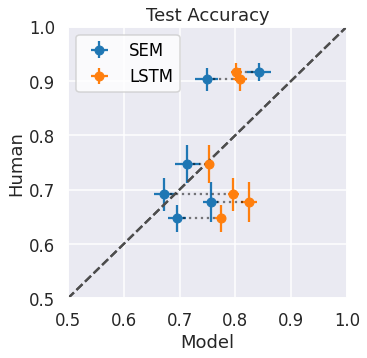

In [30]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True, sharex=True)

    plt.errorbar(y=means_hum, x=means, yerr=ses_hum,
                     xerr=np.array(sds) / np.sqrt(50),
                 ls='None', marker='o', label='SEM')
    
    plt.errorbar(y=means_hum, x=means_lstm, yerr=ses_hum,
                     xerr=np.array(sds_lstm) / np.sqrt(50),
                 ls='None', marker='o', label='LSTM')
    
    plt.plot([0.5, 1], [0.5, 1], ls="--", c=".3")
    plt.plot([0.5, 1], [0.5, 1], ls="--", c=".3")
    plt.xlim(0.5, 1.0)
    plt.ylim(0.5, 1.0)
    plt.ylabel('Human')
    plt.xlabel('Model')
    plt.title('Test Accuracy')
    
    for x, y_1, y_2 in zip(means_hum, means, means_lstm):
        plt.plot([y_1, y_2], [x, x],  ls=':', c='k', alpha=0.5)
        
plt.legend()

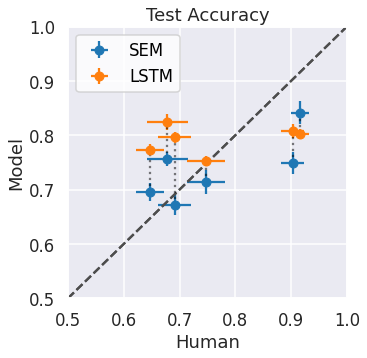

In [31]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True, sharex=True)

    plt.errorbar(x=means_hum, y=means, xerr=ses_hum,
                     yerr=np.array(sds) / np.sqrt(50),
                 ls='None', marker='o', label='SEM')
    
    plt.errorbar(x=means_hum, y=means_lstm, xerr=ses_hum,
                     yerr=np.array(sds_lstm) / np.sqrt(50),
                 ls='None', marker='o', label='LSTM')
    
    plt.plot([0.5, 1], [0.5, 1], ls="--", c=".3")
    plt.plot([0.5, 1], [0.5, 1], ls="--", c=".3")
    plt.xlim(0.5, 1.0)
    plt.ylim(0.5, 1.0)
    plt.xlabel('Human')
    plt.ylabel('Model')
    plt.title('Test Accuracy')
    
    for x, y_1, y_2 in zip(means_hum, means, means_lstm):
        plt.plot([x, x],[y_1, y_2],   ls=':', c='k', alpha=0.5)
        
plt.legend()
plt.savefig('ModelVsHuman_Scatter.png', dpi=300)

/Users/nicholasfranklin/opt/anaconda3/envs/schema/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.937
0.7353209791923625


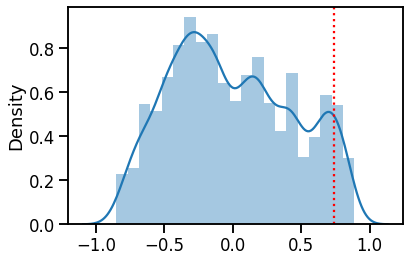

In [32]:
from scipy.stats import pearsonr

def get_r(x0, x1):
    return pearsonr(x0, x1)[0]

r_perm = [get_r(np.random.permutation(means), means_hum) 
              for _ in range(5000)]
sns.distplot(r_perm)
plt.axvline(get_r(means, means_hum), ls=':', c='r')
print(np.mean(get_r(means, means_hum) > np.array(r_perm)))
print(get_r(means, means_hum))

/Users/nicholasfranklin/opt/anaconda3/envs/schema/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.6522
0.22621886538778138


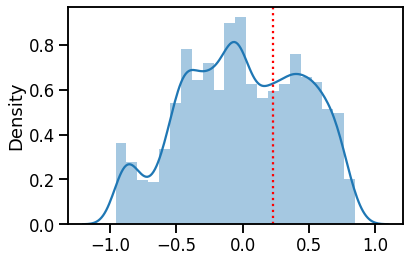

In [33]:
r_perm = [get_r(np.random.permutation(means_lstm), means_hum) 
              for _ in range(5000)]
sns.distplot(r_perm)
plt.axvline(get_r(means_lstm, means_hum), ls=':', c='r')
print(np.mean(get_r(means_lstm, means_hum) > np.array(r_perm)))
print(get_r(means_lstm, means_hum))

In [34]:
means_hum

[0.9161673632947313,
 0.902847201248364,
 0.6912784090909091,
 0.746875,
 0.6473739652671104,
 0.6776881720430109]

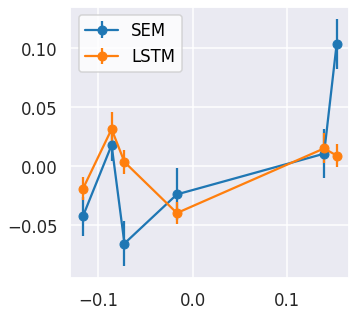

In [35]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True, sharex=True)
    
    idx = np.argsort(means_hum)

    plt.errorbar(x=np.array(means_hum)[idx] - np.mean(means_hum),
                 y=np.array(means)[idx] - np.mean(means),
                 yerr=np.array(sds)[idx] / np.sqrt(50),
                 ls='-', marker='o', label='SEM')
    
    plt.errorbar(x=np.array(means_hum)[idx] - np.mean(means_hum),
                 y=np.array(means_lstm)[idx] - np.mean(means_lstm),
#                  xerr=np.array(ses_hum)[idx],
                 yerr=np.array(sds_lstm)[idx] / np.sqrt(50), 
                 ls='-', marker='o', label='LSTM')
    
#     plt.plot([0.5, 1], [0.5, 1], ls="--", c=".3")
#     plt.plot([0.5, 1], [0.5, 1], ls="--", c=".3")
#     plt.xlim(0.5, 1.0)
#     plt.ylim(0.5, 1.0)
#     plt.xlabel('Human Test Acc')
#     plt.ylabel('Model Test Acc')
        
plt.legend()

In [36]:
def get_total_n_events(e_hat):
    return np.array([np.max(e_hat[:ii]) for ii in range(1, len(e_hat) + 1)])

def get_boundaries(e_hat):
    return np.array(
        np.concatenate([np.array([0]), e_hat[0:-1] != e_hat[1:]]), dtype=bool
    )

# trial_data = pd.read_csv(load_file)
sem_lstm_trial_data['N Total Events'] = 0.0
sem_lstm_trial_data['Boundaries'] = False
sem_lstm_trial_data.index = np.arange(len(sem_lstm_trial_data))

for b in set(sem_lstm_trial_data.batch):
    batch_data = sem_lstm_trial_data[sem_lstm_trial_data.batch == b]
    for cond in set(batch_data.Condition):
        idx = batch_data.loc[batch_data.Condition == cond, :].index
        sem_lstm_trial_data.loc[idx, 'N Total Events'] = get_total_n_events(
            batch_data.loc[idx, 'e_hat'].values)
        sem_lstm_trial_data.loc[idx, 'Boundaries'] = get_boundaries(
            batch_data.loc[idx, 'e_hat'].values)
sem_lstm_trial_data['N Total Events']+=1

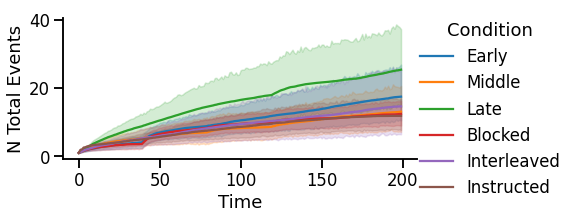

In [37]:
sns.relplot(data=sem_lstm_trial_data, x='t', y='N Total Events',
            hue='Condition', kind='line', aspect=2, height=3)
plt.xlabel('Time')
plt.savefig('CumulativeEventsOvertime.png', dpi=300)

In [38]:
early_test_df = sem_lstm_results.loc[
    (sem_lstm_results.Condition == 'Early') & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values
middle_test_df = sem_lstm_results.loc[
    (sem_lstm_results.Condition == 'Middle') & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values
late_test_df = sem_lstm_results.loc[
    (sem_lstm_results.Condition == 'Late') & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values
blk_test_df = sem_lstm_results.loc[
    (sem_lstm_results.Condition == 'Blocked') & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values
inst_test_df = sem_lstm_results.loc[
    (sem_lstm_results.Condition == 'Instructed') & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values
int_test_df = sem_lstm_results.loc[
    (sem_lstm_results.Condition == 'int_test_df') & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values


test_acc_values = {
    k: sem_lstm_results.loc[
    (sem_lstm_results.Condition == k) & 
    (sem_lstm_results.Trials == 'Test'), 'verb 2 AFC decoder Prob'].values
    for k in set(sem_lstm_results.Condition)
}

def sample_batch(condition):
    batch_n = np.random.randint(50)
    return test_acc_values[condition][batch_n]
    

# Blocked vs Interleaved
bootstrap_samples = 1000

sampled_diffs = []
sampled_diffs_plot = []


sample_size = 50
for ii in range(bootstrap_samples):
    mean_blk = np.mean([sample_batch('Blocked') for _ in range(sample_size)])
    mean_int = np.mean([sample_batch('Interleaved') for _ in range(sample_size)])
    mean_inst = np.mean([sample_batch('Instructed') for _ in range(sample_size)])
    mean_early = np.mean([sample_batch('Early') for _ in range(sample_size)])
    mean_middle = np.mean([sample_batch('Middle') for _ in range(sample_size)])
    mean_late = np.mean([sample_batch('Late') for _ in range(sample_size)])

    sampled_diffs.append({
        'Blk-Int': mean_blk-mean_int,
        'Blk>Int': mean_blk>mean_int,
        'Blk-Inst': mean_blk-mean_inst,
        'Blk>Inst': mean_blk>mean_inst,
        'Early-Middle': mean_early - mean_middle,
        'Early>Middle': mean_early > mean_middle,
        'Early-Late': mean_early - mean_late,
        'Early>Late': mean_early > mean_late,
        'Late-Middle': mean_late - mean_middle,
        'bootstrap-sample': ii,
        'Sample Size': sample_size
    })
    
    sampled_diffs_plot.append({
        'Comparison': 'Blocked > Interleaved',
        'Difference Score': mean_blk-mean_int,
        'sample': ii
    })
    sampled_diffs_plot.append({
        'Comparison': 'Blocked > Instructed',
        'Difference Score': mean_blk-mean_inst,
        'sample': ii
    })
    sampled_diffs_plot.append({
        'Comparison': 'Early > Middle',
        'Difference Score': mean_early-mean_middle,
        'sample': ii
    })
    sampled_diffs_plot.append({
        'Comparison': 'Early > Late',
        'Difference Score': mean_early-mean_late,
        'sample': ii
    })
    
    
sampled_diffs = pd.DataFrame(sampled_diffs)
sampled_diffs_plot = pd.DataFrame(sampled_diffs_plot)

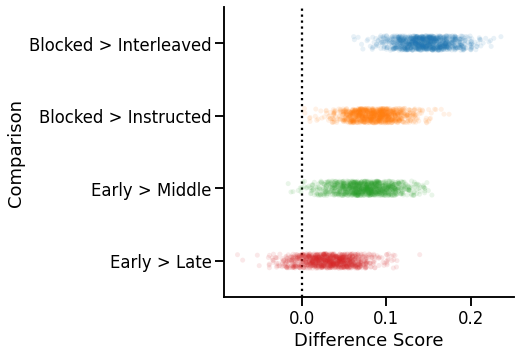

In [39]:
sns.catplot(data=sampled_diffs_plot, y='Comparison', x='Difference Score',
            aspect=1.5, alpha=0.1)
plt.axvline(x=0, c='k', ls=':')
plt.savefig('SemConditionDifferneces.png', dpi=300)

In [40]:
def summary_stats(vec):
    return np.mean(vec), \
        np.std(vec), \
        np.mean(vec > 0)
summary_stats(sampled_diffs['Blk-Int'])
    

(0.1466066290340173, 0.02714390091033404, 1.0)

In [41]:
summary_stats(sampled_diffs['Early-Middle'])

(0.07448865784968041, 0.029194662394368527, 0.993)

In [42]:
summary_stats(sampled_diffs['Early-Late'])

(0.032445866494346345, 0.02899349010623126, 0.868)

In [43]:
summary_stats(sampled_diffs['Late-Middle'])

(0.04204279135533406, 0.029666623100347157, 0.922)

# Cleanup
Move the images to somewhere sensible

In [44]:
import os
os.system('mv ./*png ./images/')

0